In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
# Load dataset
data = pd.read_csv('data/spotify_cleaned.csv')
print(data.info())

# Feature columns
feature_cols = [
    "danceability",
    "energy",
    "valence",
    "tempo",
    "acousticness",
    "instrumentalness",
    "liveness",
    "speechiness",
    "loudness"
]

# Feature matrix
X = data[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19419 entries, 0 to 19418
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  19419 non-null  object 
 1   track_name                19419 non-null  object 
 2   track_artist              19419 non-null  object 
 3   track_popularity          19419 non-null  int64  
 4   track_album_id            19419 non-null  object 
 5   track_album_name          19419 non-null  object 
 6   track_album_release_date  19419 non-null  object 
 7   playlist_name             19419 non-null  float64
 8   playlist_id               19419 non-null  object 
 9   playlist_genre            19419 non-null  object 
 10  playlist_subgenre         19419 non-null  float64
 11  danceability              19419 non-null  float64
 12  energy                    19419 non-null  float64
 13  key                       19419 non-null  int64  
 14  loudne

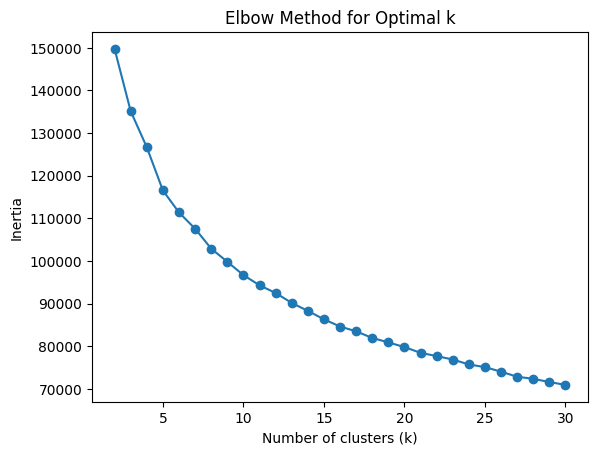

In [18]:
# 6. fit for k clusters using elbow method
k_values = range(2, 31)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# 7. Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
optimal_k = 15
kmeans_final = KMeans(n_clusters=optimal_k, n_init=20, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled)

In [20]:
spotify_df_clusters = data.copy()

# Initialize all as NaN (songs that weren't used in clustering)
spotify_df_clusters["cluster"] = np.nan

# Assign cluster labels only for rows that were in X_features (same index as X_scaled_df)
spotify_df_clusters.loc[data.index, "cluster"] = cluster_labels

print("Cluster value counts:")
print(spotify_df_clusters["cluster"].value_counts(dropna=False))

Cluster value counts:
cluster
7.0     1642
9.0     1539
12.0    1430
4.0     1430
8.0     1429
2.0     1414
5.0     1320
14.0    1311
10.0    1274
11.0    1256
3.0     1249
1.0     1147
0.0     1095
13.0    1075
6.0      808
Name: count, dtype: int64


In [21]:
def find_song_indices(df, track_name=None, track_artist=None):
    mask = pd.Series(True, index=df.index)

    if track_name is not None:
        mask &= df["track_name"].str.contains(
            track_name,
            case=False,
            na=False,
            regex=False,   
        )

    if track_artist is not None:
        mask &= df["track_artist"].str.contains(
            track_artist,
            case=False,
            na=False,
            regex=False,
        )

    return df[mask].index.tolist()


In [29]:
def get_recommendations(song_queries, n_recs=10, random_state=None):
    rng = np.random.default_rng(random_state)

    # 1) Find seed indices and their clusters
    seed_indices = []
    seed_pairs = set()
    seed_clusters = set()

    for song in song_queries:
        track_name = song.get("track_name")
        track_artist = song.get("track_artist")

        if track_name is None:
            continue

        # use your existing helper; pass df explicitly
        idxs = find_song_indices(
            spotify_df_clusters,
            track_name=track_name,
            track_artist=track_artist
        )

        if not idxs:
            print(f"[get_recommendations] Seed not found: {track_name} - {track_artist}")
            continue

        seed_indices.extend(idxs)

        for i in idxs:
            seed_clusters.add(spotify_df_clusters.at[i, "cluster"])
            seed_pairs.add((
                spotify_df_clusters.at[i, "track_name"],
                spotify_df_clusters.at[i, "track_artist"]
            ))

    if not seed_clusters:
        print("[get_recommendations] No seed clusters found; returning empty DataFrame.")
        return pd.DataFrame(columns=spotify_df_clusters.columns)

    # 2) Candidate pool = songs in those clusters
    candidates = spotify_df_clusters[
        spotify_df_clusters["cluster"].isin(seed_clusters)
    ].copy()

    # 3) Exclude all seed songs (track_name + track_artist)
    candidate_pairs = candidates[["track_name", "track_artist"]].apply(tuple, axis=1)
    candidates = candidates[~candidate_pairs.isin(seed_pairs)]

    # 4) Drop duplicates (track_name, track_artist)
    candidates = candidates.drop_duplicates(subset=["track_name", "track_artist"])

    if candidates.empty:
        print("[get_recommendations] No candidate songs after filtering.")
        return candidates

    # 5) Shuffle within each cluster for variety
    #    (and optional reproducibility via random_state)
    grouped = []
    for c, grp in candidates.groupby("cluster"):
        # shuffle using RNG
        grp = grp.sample(frac=1, random_state=rng.integers(0, 1_000_000)).reset_index(drop=True)
        grouped.append(grp)

    # 6) Round-robin across clusters to encourage diversity
    rec_rows = []
    i = 0
    while len(rec_rows) < n_recs and grouped:
        new_grouped = []
        for grp in grouped:
            if i < len(grp):
                rec_rows.append(grp.iloc[i])
                if len(rec_rows) >= n_recs:
                    break
                new_grouped.append(grp)
            else:
                # this cluster ran out of songs
                continue
        grouped = new_grouped
        i += 1
        if not grouped:
            break

    if not rec_rows:
        return pd.DataFrame(columns=candidates.columns)

    recs = pd.DataFrame(rec_rows).reset_index(drop=True)
    return recs.head(n_recs)

In [36]:
# Compute cosine similarity score between user songs and recommended songs
def cosine_similarity_score(user_songs, recommended_songs):
    user_indices = []
    rec_indices = []
    for song in user_songs:
        tname = song.get("track_name")
        aname = song.get("track_artist")
        matches = find_song_indices(data, track_name=tname, track_artist=aname)
        if matches:
            user_indices.append(matches[0])
    for _, row in recommended_songs.iterrows():
        matches = find_song_indices(data, track_name=row["track_name"], track_artist=row["track_artist"])
        if matches:
            rec_indices.append(matches[0])
    if not user_indices or not rec_indices:
        return None
    user_vectors = X_scaled[user_indices]
    rec_vectors = X_scaled[rec_indices]
    sim_matrix = cosine_similarity(user_vectors, rec_vectors)
    return sim_matrix

In [ ]:
# Example usage
user_songs = [
    {"track_name": "Don't you forget about me", "track_artist": "Simple Minds"},
    {"track_name": "Don't stop believin'", "track_artist": "Journey"},
    {"track_name": "Tainted Love", "track_artist": "Soft Cell"},
    {"track_name": "Take on Me", "track_artist": "a-ha"},
    {"track_name": "Africa", "track_artist": "Toto"},
    {"track_name": "Eye of the Tiger", "track_artist": "Survivor"},
]
recs = get_recommendations(
    song_queries=user_songs,
    n_recs=10
)

print(recs)
# Calculate and print cosine similarity score mean for each recommended song
sim_matrix = cosine_similarity_score(user_songs, recs)
if sim_matrix is not None:
    sim_means = sim_matrix.mean(axis=0)
    for i, row in recs.iterrows():
        print(f"Recommendation: {row['track_name']} - {row['track_artist']}, Cosine Similarity Score Mean: {sim_means[i]:.4f}")

[get_recommendations] Seed not found: Don't you forget about me - Simple Minds
                 track_id                                 track_name  \
0  3GUZHOhbl6hQEqsHCkUDDd                                      Do U?   
1  7t8qTDoVozTk6Sn9CMLttT       With You Tonight (Hasta El Amanecer)   
2  7KZPj8boonCcKNplZa7UvV                                Do Me Right   
3  265Anh9hGoozFigjUVLUeD                                  New Shoes   
4  5hM6sP0Gh1jD57drszNueC  For You (Fifty Shades Freed) (& Rita Ora)   
5  0vg6ueDexrELdda2VyFlCN                   Surfer Joe - Hit Version   
6  7JUZDQRGyMElJXjmcNayjx                      I'll Make Love To You   
7  0HCl2cFW2ISiJOZtZ92vJe                             Lieber sterben   
8  3m2Bsp7otjIddiGoTaiSKO       Like I Love You - Rowen Reecks Remix   
9  0PbM43TJ49KStGWa6QD0YD                                  Sinastria   

   track_artist  track_popularity          track_album_id  \
0     Do Or Die                54  6Rz6uYL1D2XlMYM1g90vm6   
1     

In [25]:
import random 
# Backtest playlist
def backtest_playlist(playlistname, seed=.8, n_rec=10):
    # Load playlist data with error handling for malformed CSV
    playlist_df = pd.read_csv('data/spotify_playlists.csv', on_bad_lines='skip', engine='python')
    
    # Convert playlistname column to string to avoid float/type issues
    playlist_df['playlistname'] = playlist_df['playlistname'].astype(str)

    # List of tuples (track_name, track_artist) for all songs in the playlist
    playlist_songs = list(
        playlist_df[playlist_df['playlistname'] == str(playlistname)][['trackname', 'artistname']].itertuples(index=False, name=None)
    )

    songCount = len(playlist_songs)
    
    # Remove songs not in data
    valid_songs = []
    for track_name, track_artist in playlist_songs:
        matches = find_song_indices(data, track_name=track_name, track_artist=track_artist)
        if matches:
            valid_songs.append((track_name, track_artist))

    validCount = len(valid_songs)

    # remove seed songs randomly
    seed_songs = random.sample(valid_songs, min(int(np.floor(validCount*seed)), validCount))

    # remove seed songs from valid songs
    for song in seed_songs:
        valid_songs.remove(song)

    # Prepare song queries for recommendation
    song_queries = [
        {"track_name": track_name, "track_artist": track_artist}
        for track_name, track_artist in seed_songs
    ]

    recs = get_recommendations(
        song_queries=song_queries,
        n_recs=n_rec
    )

    display(recs)

    # Print summary
    print(f"\nBacktest Summary for Playlist: {playlistname}")
    print(f"Total songs in playlist: {songCount}")
    print(f"Valid songs in dataset: {validCount}")
    print(f"Seed songs used: {len(seed_songs)}")
    print(f"Recommendations generated: {len(recs)}")

    # Calculate how many recommendations were actually in the original playlist
    rec_in_playlist = 0
    for _, row in recs.iterrows():
        if (row['track_name'], row['track_artist']) in valid_songs:
            rec_in_playlist += 1


    print(f"Recommendations in original playlist: {rec_in_playlist}")

In [31]:
backtest_playlist('Songs I Need', .8, 50)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock,cluster
0,4uKop5eqeLow56qacdfO1P,Breakfast In America,Supertramp,35,7i75GRwJbhDDiLi2uQHTtZ,Breakfast In America,1979-03-29,0.002163,76lrxCrKrGDkDDf3SVPnl3,rock,...,1.194508,-2.105654,159333,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,73EGkDqlDCqx57m3fpRBSw,Feel Something Again - Radio Edit,Roberto Marín Muñoz,32,66HAuGjyPR8cgBGOsUnINT,Feel Something Again,2019-10-11,0.002420,64k01l4j6QtnZ8jMaI84AA,edm,...,0.059031,0.130466,227000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4whKi0lMYWNiV2IZBkTbYB,La Mas Linda,Casper Magico,70,7uznfTbxuwk5EUtIkD8gRT,La Mas Linda,2019-12-13,0.002008,37i9dQZF1DX4OjfOteYnH8,rap,...,-0.347677,-1.197179,211888,0.0,0.0,0.0,0.0,1.0,0.0,2.0
3,6c0i4gSQ0Ia5VBPRhTH6CG,Never Let You Go - Radio Edit,Dash Berlin,23,0l9OhTUJz7I3YSZEE2T14s,Never Let You Go,2015-02-23,0.004017,0o5gKmuET7F3lQnpFxvPO8,edm,...,-0.915187,0.441232,182139,1.0,0.0,0.0,0.0,0.0,0.0,4.0
4,1WrVjFkswM2JthLruEiCoD,Prefiero,Jere Profeta,0,0NkOhSaCHPr2x5brYhu3pF,Prefiero,2018-12-04,0.001751,37i9dQZF1DWTLxOkM7PwUb,rap,...,0.255701,0.286421,193548,0.0,0.0,0.0,0.0,1.0,0.0,5.0
5,53xSIYBcFnltfPf6ZyQ4je,Heaven,The Neighbourhood,0,1xHCCotLePVxUhgxckUtLB,To Imagine - EP,2018-01-12,0.004068,1YgWQAs1s77NzieIH4ARKn,pop,...,-1.102842,1.213007,205800,0.0,0.0,1.0,0.0,0.0,0.0,6.0
6,765ZpBQUUFKAVjzVyW77if,stop and stare,joan,47,2x0dCdfqGuqk7e9eJsUsjU,portra,2018-07-11,0.012256,21nxmipQe5xtXoHHPaYfnY,pop,...,0.059031,-0.892301,201953,0.0,0.0,1.0,0.0,0.0,0.0,7.0
7,4T6p9mFEP9J1HbQWfdIP6F,Guilty Pleasure,Bryce Vine,50,3FxhIYHnMRF3172VF5f5RR,Lazy Fair,2014-04-15,0.004120,4ZO0wp9G8FA3X6oYNBzda6,pop,...,1.337586,1.213593,204435,0.0,0.0,1.0,0.0,0.0,0.0,8.0
8,2DMqiPZ8uLE2AtwHLInHOI,Silverskin,Sam Feldt,8,3DXfe2cEsCdAjORfXw0NDK,Sunrise To Sunset,2017-11-24,0.003759,37i9dQZF1DX0AMssoUKCz7,latin,...,1.002255,-0.941014,151219,0.0,1.0,0.0,0.0,0.0,0.0,10.0
9,2LbkpJUH052AvFcNIgjHTO,Mony Mony - Downtown Mix / 24-Bit Digitally Re...,Billy Idol,52,0XGgMqKNcQgd0i9YHFiPei,Vital Idol,1985,0.001648,4lIywN6kXl9KPm3OQ8u8G7,rock,...,-0.222542,0.699850,301800,0.0,0.0,0.0,0.0,0.0,1.0,12.0



Backtest Summary for Playlist: Songs I Need
Total songs in playlist: 367
Valid songs in dataset: 52
Seed songs used: 41
Recommendations generated: 50
Recommendations in original playlist: 0


In [32]:
backtest_playlist('chill out', .8, 50)

KeyboardInterrupt: 